# Need to figure out what to  do with random ingredients at your house?
## Do not fear.. we can probably find some recipe for you to use those three week old carrots

Start with packages you need to run the program

In [2]:
##### import stuff we need!
import pandas as pd
import re
## https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
## its maybe better to use TfidVectorizer than PCA for text? https://stackoverflow.com/questions/34725726/is-it-possible-apply-pca-on-any-text-classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from data_utils import RandomForestClassifier, StandardScaler
from data_utils import KMeansClustering, SpectralClustering
from data_utils import object_from_json_url, classification_error, display_confusion_matrix

from image_utils import make_image, open_image


### Import recipes list json file 

In [3]:
# Load the dataset
recipes_path = "./data/recipes.json"
recipes_df = pd.read_json(recipes_path)

### Cluster the recipes into groups

In [4]:
# TF-IDF and clustering
##look into editing this
recipes_df['ingredients_string'] = recipes_df['ingredients'].apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(recipes_df['ingredients_string'])
print(X.shape)  # Output: (num_samples, num_features)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
recipes_df['cuisine'] = kmeans.fit_predict(X)
unique_labels = [chr(i) for i in range(65, 65 + n_clusters)]
recipes_df['cuisine'] = recipes_df['cuisine'].map(lambda x: unique_labels[x])
recipes_df.to_csv('clustered.csv', index=False)

(9944, 1000)


### By looking at clustered.csv - we can see the groups vaguely look like:

- **Cluster A (Desserts / Baked Goods / Sweet)**: These recipes include common dessert ingredients like sugar, eggs, flour, and fruit.
- **Cluster B (Indian / Middle Eastern / Spicy Savory)**: Spices like cumin, curry powder, turmeric, and the use of yogurt and rice support this classification.
- **Cluster C (Asian / Fusion / Lightly Spiced)**: Ingredients like soy sauce, ginger, garlic, and tofu suggest an Asian or fusion theme.
- **Cluster D (Mexican / Tex-Mex / Spicy)**: Ingredients like chili powder, cumin, and tortillas suggests this cluster includes these types of dishes.
- **Cluster E (Savory / Meat-Based)**: Primarily composed of savory, often meat-heavy recipes.

I am going to plot these to see if by looking at them the groups seem meaningful and distinct. The easiest way to do that is by doing a PCA on them. The PCA is not used for the analysis, only for visual confirmation that these groups seem okay.

(9944, 3)


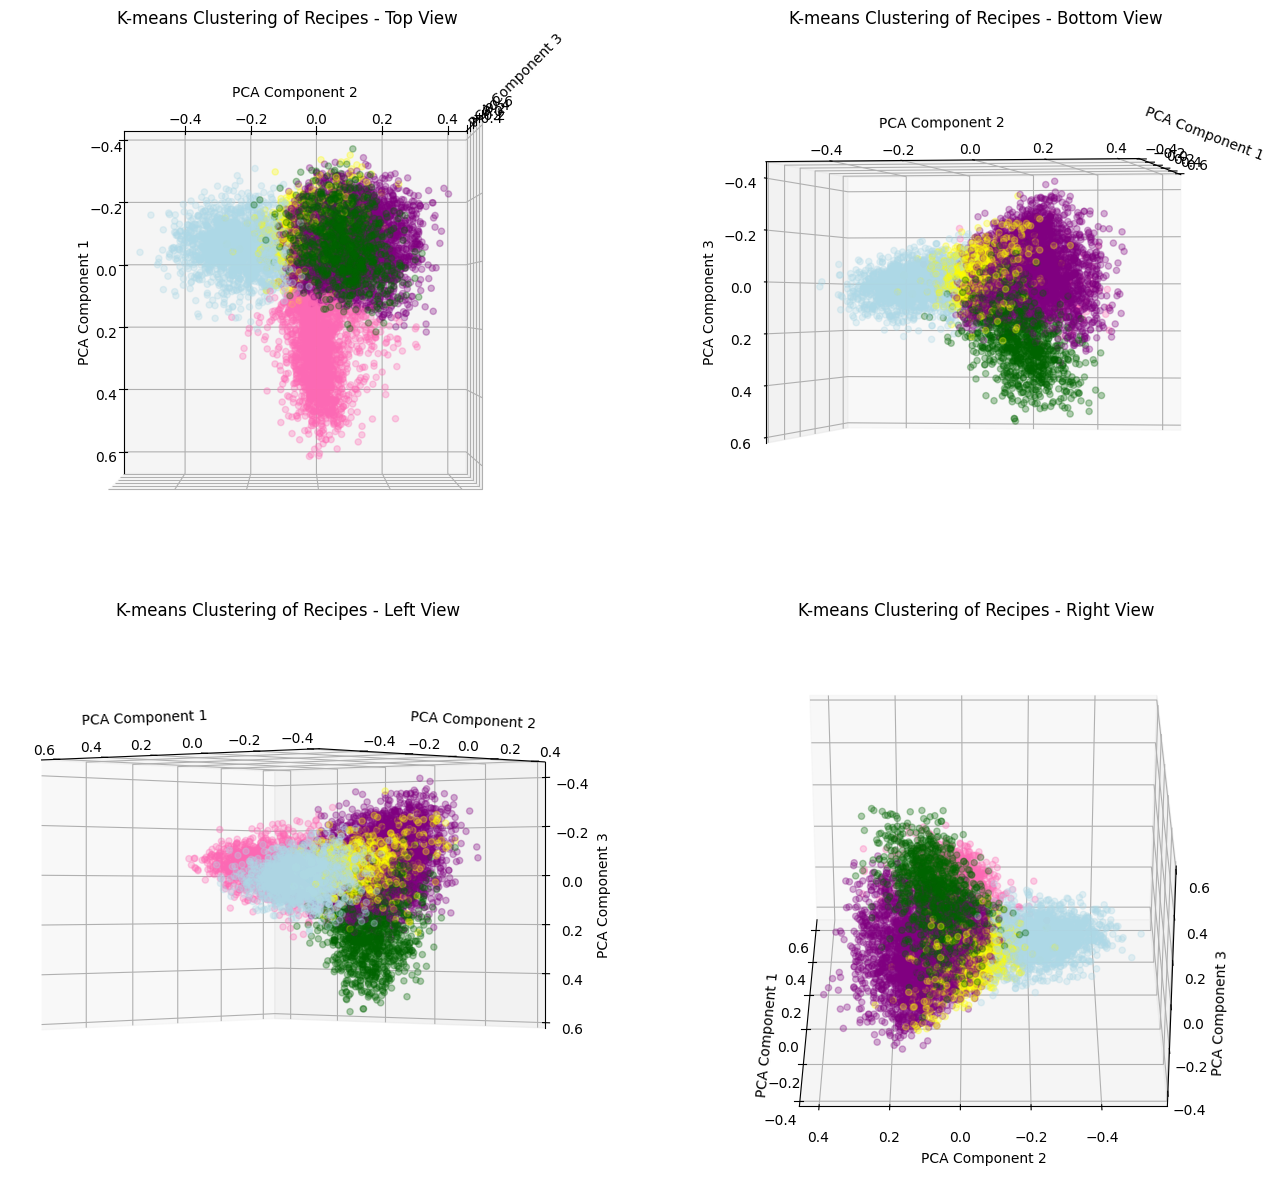

In [11]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())
print(X_pca.shape)
fig = plt.figure(figsize=(15, 12))

# Define the views ## got help here from CHATGPT because I wanted four distinct views to be able to see the data from all sides
views = [
    {'elev': 90, 'azim': 0, 'title': 'Top View'},      # Top view (elev=90, azim=0)
    {'elev': -180, 'azim': -10, 'title': 'Bottom View'},  # Bottom view (elev=270, azim=0)
    {'elev': 180, 'azim': 50, 'title': 'Left View'},     # Left view (elev=0, azim=90)
    {'elev': 30, 'azim': 180, 'title': 'Right View'}
]

colors = ['#FF69B4', '#FFFF00', '#ADD8E6', '#006400', '#800080'] 


for i, view in enumerate(views):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')  
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                         c=recipes_df['cuisine'].map({label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}),
                         marker='o', alpha=0.3)  
    
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    ax.set_title(f"K-means Clustering of Recipes - {view['title']}")
    
    ax.view_init(elev=view['elev'], azim=view['azim'])

plt.tight_layout()  
plt.show()


### I think that looks good! I can see five distinct colors. 

I think its also interesting to see what is the main component of each PCA component, just so we can understand the recipes better.

In [16]:
# Get the indices of the most important features for each component 

top_n = 5  # Get top 5 features for each component
for i in range(pca.components_.shape[0]):  
    component = pca.components_[i]
    top_features_idx = np.argsort(np.abs(component))[-top_n:]  ##was getting an error in this loop that i fixed with chatgpt
    print(f"Top {top_n} features for PCA component {i+1}:")
    for idx in top_features_idx:
        print(f"  {vectorizer.get_feature_names_out()[idx]} (weight: {component[idx]:.3f})")


Top 5 features for PCA component 1:
  eggs (weight: 0.203)
  purpose (weight: 0.209)
  pepper (weight: -0.224)
  flour (weight: 0.254)
  sugar (weight: 0.260)
Top 5 features for PCA component 2:
  rice (weight: -0.195)
  sesame (weight: -0.252)
  soy (weight: -0.300)
  sauce (weight: -0.336)
  cheese (weight: 0.340)
Top 5 features for PCA component 3:
  lemon (weight: -0.213)
  cream (weight: 0.217)
  shredded (weight: 0.225)
  fresh (weight: -0.229)
  cheese (weight: 0.305)


### It seems like PCA component 1 has a lot of baking ingredients, and if we look at the 3d graph above, there is a pink group that seems like it hs a lot of that, that probably cluster A which is our baked goods. PCA component 2 has negative values for rice, sesame, soy, and sauce - so things low on that PCA component are probably Asian (because its the inverse relation)- I think that's the light blue group.

Now, we have groups that we feel okay about. Next step is to `make our code be able to return recipes that contain ingredients we provide it, based on the clusters we created.`


In [17]:
def word_match(input_ingredient, recipe_ingredient):
    # make both INPUT and RECIPE ingredients lower case
    input_ingredient = input_ingredient.lower()
    recipe_ingredient = recipe_ingredient.lower()
    #check if input_ingredient is present as a whole word in a recipe ingredient, and returns True if found
    # for example, if the input is egg and recipe ingredient is eggplant, it will make sure the boundary around 'egg'' is not a letter connected to it from each end and will return false
    return bool(re.search(r'\b' + re.escape(input_ingredient) + r'\b', recipe_ingredient))


## my example that i am using here is egg vs eggplant
print("TEST FOR WORD MATCH - this should be true", word_match("egg", "egg whites"))
print("TEST FOR WORD MATCH - this should be false", word_match("egg", "eggplant"))
## yay it passed

def find_matching_recipe(input_ingredients, recipes_df, cluster):
    # keep only the chosen cluster of recipes
    recipes_in_cluster = recipes_df[recipes_df['cuisine'] == cluster]
    # list for recipes that match, we will append to this later
    matching_recipes = []
    # go through each recipe in the cluster

    for i, row in recipes_in_cluster.iterrows():
        recipe_id = row['id']
        recipe_ingredients = row['ingredients']
        # Go through each INPUT ingredient
        all_ingredients_match = True  # start with all ingredients match initially
        for input_ingredient in input_ingredients:
            # Set default match found to false for the current INPUT ingredient
            ingredient_found = False
            # Go through each RECIPE ingredient
            for recipe_ingredient in recipe_ingredients:
                # Check if they match using word_match function
                if word_match(input_ingredient, recipe_ingredient):
                    ingredient_found = True
                    break  
            # If no match found for this ingredient stop checking
            if not ingredient_found:
                all_ingredients_match = False
                break  
        # If all input ingredients were found in the recipe ingredients, add it to the list
        if all_ingredients_match:
            matching_recipes.append(recipe_id)
    return matching_recipes if matching_recipes else None

# This is where we choose ingredients input and cluster
input_ingredients = ["white wine", "soy sauce"]
assigned_cluster = 'C'
matching_recipe_ids = find_matching_recipe(input_ingredients, recipes_df, assigned_cluster)

if matching_recipe_ids:
    print("Matching recipe ID(s) for Cluster", assigned_cluster, ":", matching_recipe_ids)
else:
    print("No recipe found in Cluster", assigned_cluster, "that contains all the ingredients.")


TEST FOR WORD MATCH - this should be true True
TEST FOR WORD MATCH - this should be false False
Matching recipe ID(s) for Cluster C : [4092, 17585, 23677, 21611, 31595, 22967, 44083, 36969, 7223, 48805, 26679, 32666]


In [18]:
# This is a quick test to see which cluster each recipe is in, it's useful for testing
recipe_id = 7223
recipe_cluster = recipes_df[recipes_df['id'] == recipe_id]['cuisine']
if not recipe_cluster.empty:
    print("Recipe ID", recipe_id, "is in cluster:", recipe_cluster.iloc[0])
else:
    print("Recipe ID", recipe_id, "not found in the dataset.")

Recipe ID 7223 is in cluster: C


### Now we have a code that can return potential recipes to make, within a type of food group you want to make, based on ingredients you want to use. But what if it returns a recipe that you are missing an ingredient for?

### **Now we need to figure out which ingredients are similar and can be used as a replacement**


In [19]:
#### DOWNLOAD INGREDIENTS LIST 
nutr_df = pd.read_csv('ingredients.csv')

# need to simplify the ingredient names, so made a dictionary that is easier to deal with
column_mapping = {
    'Data.Alpha Carotene': 'Alpha_Carotene',
    'Data.Beta Carotene': 'Beta_Carotene',
    'Data.Beta Cryptoxanthin': 'Beta_Cryptoxanthin',
    'Data.Carbohydrate': 'Carbohydrate',
    'Data.Cholesterol': 'Cholesterol',
    'Data.Choline': 'Choline',
    'Data.Fiber': 'Fiber',
    'Data.Lutein and Zeaxanthin': 'Lutein_Zeaxanthin',
    'Data.Lycopene': 'Lycopene',
    'Data.Niacin': 'Niacin',
    'Data.Protein': 'Protein',
    'Data.Retinol': 'Retinol',
    'Data.Riboflavin': 'Riboflavin',
    'Data.Selenium': 'Selenium',
    'Data.Sugar Total': 'Sugar_Total',
    'Data.Thiamin': 'Thiamin',
    'Data.Water': 'Water',
    'Data.Fat.Monosaturated Fat': 'Monosaturated_Fat',
    'Data.Fat.Polysaturated Fat': 'Polysaturated_Fat',
    'Data.Fat.Saturated Fat': 'Saturated_Fat',
    'Data.Fat.Total Lipid': 'Total_Lipid_Fat',
    'Data.Major Minerals.Calcium': 'Calcium',
    'Data.Major Minerals.Copper': 'Copper',
    'Data.Major Minerals.Iron': 'Iron',
    'Data.Major Minerals.Magnesium': 'Magnesium',
    'Data.Major Minerals.Phosphorus': 'Phosphorus',
    'Data.Major Minerals.Potassium': 'Potassium',
    'Data.Major Minerals.Sodium': 'Sodium',
    'Data.Major Minerals.Zinc': 'Zinc',
    'Data.Vitamins.Vitamin A - RAE': 'Vitamin_A_RAE',
    'Data.Vitamins.Vitamin B12': 'Vitamin_B12',
    'Data.Vitamins.Vitamin B6': 'Vitamin_B6',
    'Data.Vitamins.Vitamin C': 'Vitamin_C',
    'Data.Vitamins.Vitamin E': 'Vitamin_E',
    'Data.Vitamins.Vitamin K': 'Vitamin_K'
}
# Rename the columns using the dictionary above
nutr_df.rename(columns=column_mapping, inplace=True)
# Save the updated DataFrame back to a CSV file
nutr_df.to_csv('ingredient_nutrition.csv', index=False)

##similarly, the rows need to be simplified.
## the goal is to:
# 1- categorize all similar items as the same thing (so every type of cheese is cheese, etc) as much as possible
# 2- collapse data and create new rows that have non-repeated ingredients that have an average value of the nutritional value columns from above

## make dictionary that would later be used to collapse the rows by
## i still need to go through these more and clean them up, there are some that can be further collapsed
simple_ingredient_map = {
    "Butter": "Butter",
    "Butter oil": "Butter Oil",
    "Cheese": "Cheese",
    "Cheese spread": "Cheese",
    "Cream": "Cream",
    "Eggnog": "Eggnog",
    "Cream substitute": "Cream Substitute",
    "Dessert topping": "Dessert Topping",
    "Sour cream": "Sour Cream",
    "Milk": "Milk",
    "Whey": "Whey",
    "Yogurt": "Yogurt",
    "Egg": "Egg",
    "Cheese sauce": "Cheese Sauce",
    "Parmesan cheese topping": "Cheese",
    "Cheese product": "Cheese",
    "Protein supplement": "Protein Supplement",
    "Dulce de Leche": "Dulce de Leche",
    "Egg substitute": "Egg Substitute",
    "Ice cream": "Ice Cream",
    "Ice cream cone": "Ice Cream",
    "Fat free ice cream": "Ice Cream",
    "Ice cream bar": "Ice Cream",
    "Kefir": "Kefir",
    "Light ice cream": "Ice Cream",
    "Spices": "Spices",
    "Basil": "Basil",
    "Mustard": "Mustard",
    "Salt": "Salt",
    "Vinegar": "Vinegar",
    "Vanilla extract": "Vanilla Extract",
    "Capers": "Capers",
    "Horseradish": "Horseradish",
    "Clif Z bar": "Clif Z Bar",
    "Babyfood": "Baby Food",
    "Zwieback": "Zwieback",
    "Infant formula": "Infant Formula",
    "Child formula": "Child Formula",
    "Toddler formula": "Toddler Formula",
    "Fat": "Fat",
    "Lard": "Lard",
    "Salad dressing": "Salad Dressing",
    "Sandwich spread": "Sandwich Spread",
    "Oil": "Oil",
    "Margarine": "Margarine",
    "Shortening industrial": "Shortening",
    "Animal fat": "Animal Fat",
    "Margarine-like": "Margarine-like",
    "Shortening": "Shortening",
    "Dressing": "Dressing",
    "Mayonnaise": "Mayonnaise",
    "Chicken": "Chicken",
    "Duck": "Duck",
    "Goose": "Goose",
    "Turkey": "Turkey",
    "Chicken patty": "Chicken Patty",
    "Ostrich": "Ostrich",
    "Turkey from whole": "Whole Turkey",
    "Soup": "Soup",
    "CAMPBELL'S": "Campbell's Soup",
    "Sauce": "Sauce",
    "Gravy": "Gravy",
    "Split pea soup": "Split Pea Soup",
    "Split pea with ham soup": "Split Pea with Ham Soup",
    "Fish broth": "Fish Broth",
    "Blood sausage": "Blood Sausage",
    "Bologna": "Bologna",
    "Bratwurst": "Bratwurst",
    "Braunschweiger (a liver sausage)": "Braunschweiger",
    "Frankfurter": "Frankfurter",
    "Ham": "Ham",
    "Ham salad spread": "Ham Salad Spread",
    "Headcheese": "Headcheese",
    "Knackwurst": "Knackwurst",
    "Roast beef": "Roast Beef",
    "Mortadella": "Mortadella",
    "Pate": "Pâté",
    "Pepperoni": "Pepperoni",
    "Pickle and pimiento loaf": "Pickle Loaf",
    "Pork sausage": "Pork Sausage",
    "Poultry salad sandwich spread": "Poultry Salad Spread",
    "Salami": "Salami",
    "Thuringer": "Thuringer",
    "Turkey breast": "Turkey Breast",
    "Sausage": "Sausage",
    "Luncheon meat": "Luncheon Meat",
    "Scrapple": "Scrapple",
    "Chicken breast": "Chicken Breast",
    "Kielbasa": "Kielbasa",
    "Bacon": "Bacon",
    "Cereals ready-to-eat": "Cereal",
    "Cereals": "Cereal",
    "Milk and cereal bar": "Cereal",
    "Rice and Wheat cereal bar": "Cereal",
    "Apples": "Apples",
    "Apple juice": "Apple",
    "Applesauce": "Applesauce",
    "Apricots": "Apricots",
    "Apricot nectar": "Apricot",
    "Avocados": "Avocados",
    "Bananas": "Bananas",
    "Blackberries": "Blackberries",
    "Blackberry juice": "Blackberry",
    "Cherries": "Cherries",
    "Blueberries": "Blueberries",
    "Breadfruit": "Breadfruit",
    "Carambola": "Carambola",
    "Cranberries": "Cranberries",
    "Cranberry sauce": "Cranberry Sauce",
    "Currants": "Currants",
    "Dates": "Dates",
    "Figs": "Figs",
    "Fruit cocktail": "Fruit Cocktail",
    "Grapefruit": "Grapefruit",
    "Grapefruit juice": "Grapefruit",
    "Grape juice": "Grape",
    "Grapes": "Grapes",
    "Guavas": "Guavas",
    "Guava sauce": "Guava",
    "Kiwifruit": "Kiwifruit",
    "Kumquats": "Kumquats",
    "Lemons": "Lemons",
    "Lemon juice": "Lemon",
    "Lemon juice from concentrate": "Lemon",
    "Lemon peel": "Lemon Peel",
    "Limes": "Limes",
    "Lime juice": "Lime",
    "Litchis": "Lychees",
    "Mangos": "Mangos",
    "Melons": "Melons",
    "Nectarines": "Nectarines",
    "Olives": "Olives",
    "Oranges": "Oranges",
    "Orange juice": "Orange",
    "Tangerines": "Tangerines",
    "Tangerine juice": "Tangerine",
    "Papayas": "Papayas",
    "Papaya nectar": "Papaya",
    "Passion-fruit": "Passionfruit",
    "Passion-fruit juice": "Passionfruit",
    "Peaches": "Peaches",
    "Peach nectar": "Peach",
    "Pears": "Pears",
    "Pear nectar": "Pear",
    "Persimmons": "Persimmons",
    "Pineapple": "Pineapple",
    "Pineapple juice": "Pineapple",
    "Plantains": "Plantains",
    "Plums": "Plums",
    "Pomegranates": "Pomegranates",
    "Prune juice": "Prune",
    "Raisins": "Raisins",
    "Raspberries": "Raspberries",
    "Rhubarb": "Rhubarb",
    "Strawberries": "Strawberries",
    "Tamarinds": "Tamarinds",
    "Watermelon": "Watermelon",
    "Maraschino cherries": "Maraschino Cherries",
    "Candied fruit": "Candied Fruit",
    "Guanabana nectar": "Guanabana",
    "Mango nectar": "Mango",
    "Pomegranate juice": "Pomegranate",
    "Pork": "Pork",
    "Canadian bacon": "Bacon",
    "Alfalfa seeds": "Alfalfa Seeds",
    "Artichokes": "Artichokes",
    "Asparagus": "Asparagus",
    "Balsam-pear (bitter gourd)": "Bitter Gourd",
    "Bamboo shoots": "Bamboo Shoots",
    "Lima beans": "Lima Beans",
    "Mung beans": "Mung Beans",
    "Beans": "Beans",
    "Beets": "Beets",
    "Beet greens": "Beet Greens",
    "Broccoli": "Broccoli",
    "Broccoli raab": "Broccoli Raab",
    "Brussels sprouts": "Brussels Sprouts",
    "Burdock root": "Burdock Root",
    "Cabbage": "Cabbage",
    "Carrots": "Carrots",
    "Cassava": "Cassava",
    "Cauliflower": "Cauliflower",
    "Celeriac": "Celeriac",
    "Celery": "Celery",
    "Chard": "Chard",
    "Chayote": "Chayote",
    "Chives": "Chives",
    "Collards": "Collards",
    "Coriander (cilantro) leaves": "Cilantro",
    "Corn": "Corn",
    "Cowpeas (blackeyes)": "Cowpeas",
    "Cress": "Cress",
    "Cucumber": "Cucumber",
    "Dandelion greens": "Dandelion Greens",
    "Eggplant": "Eggplant",
    "Edamame": "Edamame",
    "Escarole": "Escarole",
    "Garlic": "Garlic",
    "Ginger root": "Ginger",
    "Kale": "Kale",
    "Kohlrabi": "Kohlrabi",
    "Lambsquarters": "Lambsquarters",
    "Leeks": "Leeks",
    "Lettuce": "Lettuce",
    "Lotus root": "Lotus Root",
    "Mushrooms": "Mushrooms",
    "Mustard greens": "Mustard Greens",
    "Okra": "Okra",
    "Onions": "Onions",
    "Onion rings": "Onion Rings",
    "Parsley": "Parsley",
    "Parsnips": "Parsnips",
    "Peas": "Peas",
    "Peppers": "Peppers",
    "Pokeberry shoots": "Pokeberry Shoots",
    "Potatoes": "Potatoes",
    "Potato puffs": "Potato Puffs",
    "Potato flour": "Potato Flour",
    "Pumpkin flowers": "Pumpkin Flowers",
    "Pumpkin": "Pumpkin",
    "Radishes": "Radishes",
    "Rutabagas": "Rutabagas",
    "Salsify": "Salsify",
    "Sauerkraut": "Sauerkraut",
    "Seaweed": "Seaweed",
    "Spinach": "Spinach",
    "Squash": "Squash",
    "Sweet potato leaves": "Sweet Potato Leaves",
    "Sweet potato": "Sweet Potato",
    "Taro": "Taro",
    "Taro leaves": "Taro Leaves",
    "Tomatoes": "Tomatoes",
    "Tomato juice": "Tomato",
    "Tomato products": "Tomato Products",
    "Turnips": "Turnips",
    "Turnip greens": "Turnip Greens",
    "Vegetable juice cocktail": "Vegetable Juice",
    "Vegetables": "Vegetables",
    "Waterchestnuts": "Waterchestnuts",
    "Watercress": "Watercress",
    "Waxgourd": "Waxgourd",
    "Yam": "Yam",
    "Yambean (jicama)": "Jicama",
    "Carrot juice": "Carrot",
    "Catsup": "Ketchup",
    "Pickles": "Pickles",
    "Pimento": "Pimento",
    "Pickle relish": "Pickle Relish",
    "Radicchio": "Radicchio",
    "Tomatillos": "Tomatillos",
    "Fennel": "Fennel",
    "Arugula": "Arugula",
    "Nopales": "Nopales",
    "Grape leaves": "Grape Leaves",
    "Pepper": "Pepper",
    "Seeds": "Seeds",
    "Nuts": "Nuts",
    "Beef": "Beef",
    "Alcoholic beverage": "Alcohol",
    "Beverages": "Beverages",
    "Carbonated beverage": "Carbonated Beverage",
    "Cranberry juice cocktail": "Cranberry",
    "Alcoholic beverages": "Alcoholic Beverages",
    "Lemonade": "Lemonade",
    "Malt beverage": "Malt Beverage",
    "Shake": "Shake",
    "Strawberry-flavor beverage mix": "Strawberry Beverage Mix",
    "Water": "Water",
    "Fish": "Fish",
    "Crustaceans": "Crustaceans",
    "Mollusks": "Mollusks",
    "Broadbeans (fava beans)": "Fava Beans",
    "Chickpeas (garbanzo beans)": "Chickpeas",
    "Chili with beans": "Chili",
    "Cowpeas": "Cowpeas",
    "Lentils": "Lentils",
    "Noodles": "Noodles",
    "Peanuts": "Peanuts",
    "Peanut butter": "Peanut Butter",
    "Peanut flour": "Peanut Flour",
    "Refried beans": "Refried Beans",
    "Soybeans": "Soybeans",
    "Miso": "Miso",
    "Natto": "Natto",
    "Soy flour": "Soy Flour",
    "Soy protein isolate": "Soy Protein",
    "Soy sauce made from soy and wheat (shoyu)": "Soy Sauce",
    "Tofu": "Tofu",
    "Soymilk": "Soymilk",
    "Veggie burgers or soyburgers": "Veggie Burgers",
    "Peanut spread": "Peanut Spread",
    "Soymilk (all flavors)": "Soymilk",
    "Lamb": "Lamb",
    "Veal": "Veal",
    "Game meat": "Game Meat",
    "Bagels": "Bagels",
    "Biscuits": "Biscuits",
    "Bread": "Bread",
    "Cake": "Cake",
    "Cookies": "Cookies",
    "Puff pastry": "Puff Pastry",
    "Crackers": "Crackers",
    "Cream puff shell": "Cream Puff Shell",
    "Croissants": "Croissants",
    "Croutons": "Croutons",
    "Danish pastry": "Danish Pastry",
    "Doughnuts": "Doughnuts",
    "Muffins": "Muffins",
    "Ice cream cones": "Ice Cream Cone",
    "Pancakes plain": "Pancakes",
    "Pancakes": "Pancakes",
    "Pie": "Pie",
    "Pie crust": "Pie Crust",
    "Phyllo dough": "Phyllo Dough",
    "Rolls": "Rolls",
    "Strudel": "Strudel",
    "Sweet rolls": "Sweet Rolls",
    "Taco shells": "Taco Shells",
    "Tortillas": "Tortillas",
    "Leavening agents": "Leavening Agents",
    "Tart": "Tart",
    "Waffle": "Waffle",
    "Toaster Pastries": "Toaster Pastries",
    "Muffin": "Muffin",
    "Garlic bread": "Garlic Bread",
    "Cinnamon buns": "Cinnamon Buns",
    "Cream puff": "Cream Puff",
    "Focaccia": "Focaccia",
    "SCHIFF": "Schiff",
    "Candies": "Candies",
    "Snacks": "Snacks",
    "Fruit syrup": "Fruit Syrup",
    "Syrup": "Syrup",
    "Baking chocolate": "Baking Chocolate",
    "Ice creams": "Ice Cream",
    "Sherbet": "Sherbet",
    "Chocolate-flavored hazelnut spread": "Hazelnut Spread",
    "Syrups": "Syrup",
    "Toppings": "Toppings",
    "Chewing gum": "Chewing Gum",
    "Cocoa": "Cocoa",
    "Gelatin desserts": "Gelatin",
    "Gelatins": "Gelatin",
    "Puddings": "Pudding",
    "Frostings": "Frosting",
    "Frozen novelties": "Frozen Novelties",
    "Frozen yogurts": "Frozen Yogurt",
    "Fruit butters": "Fruit Butter",
    "Honey": "Honey",
    "Jams and preserves": "Jam",
    "Jellies": "Jelly",
    "Marmalade": "Marmalade",
    "Molasses": "Molasses",
    "Pie fillings": "Pie Filling",
    "Sugars": "Sugar",
    "Sweeteners": "Sweetener",
    "Snack": "Snack",
    "Cheese puffs and twists": "Cheese Puffs",
    "Potato chips": "Potato Chips",
    "Sweetener": "Sweetener",
    "Jams": "Jam",
    "Barley": "Barley",
    "Buckwheat groats": "Buckwheat",
    "Buckwheat flour": "Buckwheat Flour",
    "Bulgur": "Bulgur",
    "Corn flour": "Corn Flour",
    "Cornmeal": "Cornmeal",
    "Cornstarch": "Cornstarch",
    "Couscous": "Couscous",
    "Hominy": "Hominy",
    "Millet": "Millet",
    "Oat bran": "Oat Bran",
    "Rice": "Rice",
    "Rice flour": "Rice Flour",
    "Rye flour": "Rye Flour",
    "Tapioca": "Tapioca",
    "Wheat bran": "Wheat Bran",
    "Wheat flour": "Wheat Flour",
    "Wild rice": "Wild Rice",
    "Macaroni": "Macaroni",
    "Pasta": "Pasta",
    "Rice noodles": "Rice Noodles",
    "Quinoa": "Quinoa",
    "Fast foods": "Fast Food",
    "Fast food": "Fast Food",
    "Pizza": "Pizza",
    "Yogurt parfait": "Yogurt Parfait",
    "School Lunch": "School Lunch",
    "Macaroni and Cheese": "Mac and Cheese",
    "HOT POCKETS": "Hot Pockets",
    "HOT POCKETS Ham 'N Cheese Stuffed Sandwich": "Hot Pockets Ham and Cheese",
    "Ravioli": "Ravioli",
    "Tortellini": "Tortellini",
    "Tofu skin": "Tofu Skin",
    "Dim sum": "Dim Sum",
    "Wonton wrappers": "Wonton Wrappers",
    "Chocolate": "Chocolate"
}

ingredient_column = 'Category'
# Apply the mapping dictionary to create the new 'simple_ingr' column
nutr_df['simple_ingr'] = nutr_df[ingredient_column].map(simple_ingredient_map).fillna(nutr_df[ingredient_column])

# Save the updated DataFrame to a new csv
nutr_df.to_csv('ingredients_with_simple.csv', index=False)

# check!
print(nutr_df.head())



     Category                 Description  Nutrient Data Bank Number  \
0      Butter              Butter, salted                       1001   
1      Butter  Butter, whipped, with salt                       1002   
2  Butter oil       Butter oil, anhydrous                       1003   
3      Cheese                Cheese, blue                       1004   
4      Cheese               Cheese, brick                       1005   

   Alpha_Carotene  Beta_Carotene  Beta_Cryptoxanthin  Carbohydrate  \
0               0            158                   0          0.06   
1               1            135                   6          0.00   
2               0            193                   0          0.00   
3               0             74                   0          2.34   
4               0             76                   0          2.79   

   Cholesterol  Choline  Fiber  ...  Potassium  Sodium  Zinc  Vitamin_A_RAE  \
0          215     18.8    0.0  ...         24     643  0.09       

### now collapse!!

In [20]:
numeric_columns = nutr_df.select_dtypes(include=['number']).columns

# Group by 'simple_ingr' and calculate the mean for the numeric columns
nutr_df_grouped = nutr_df.groupby('simple_ingr')[numeric_columns].mean().reset_index()

#check by saving and printing first few rows
nutr_df_grouped.to_csv('collapsed_ingredients.csv', index=False)
print(nutr_df_grouped.head())


           simple_ingr  Nutrient Data Bank Number  Alpha_Carotene  \
0              Alcohol                   17777.25             0.0   
1  Alcoholic Beverages                   14252.00             0.0   
2        Alfalfa Seeds                   11001.00             6.0   
3           Animal Fat                    4609.00             0.0   
4                Apple                    9237.50             0.0   

   Beta_Carotene  Beta_Cryptoxanthin  Carbohydrate  Cholesterol  Choline  \
0         1.9375                 0.0      9.615625        3.625    4.125   
1         0.0000                 0.0      2.035000        0.000    5.050   
2        87.0000                 6.0      2.100000        0.000   14.400   
3         0.0000                 0.0      0.000000       95.000   42.200   
4         0.0000                 0.0     18.772500        0.000    2.975   

   Fiber  Lutein_Zeaxanthin  ...  Phosphorus  Potassium    Sodium      Zinc  \
0  0.000             0.4375  ...     13.0625    4

['Alpha_Carotene', 'Beta_Carotene', 'Beta_Cryptoxanthin', 'Carbohydrate', 'Cholesterol', 'Choline', 'Fiber', 'Lutein_Zeaxanthin', 'Lycopene', 'Niacin', 'Protein', 'Retinol', 'Riboflavin', 'Selenium', 'Sugar_Total', 'Thiamin', 'Water', 'Monosaturated_Fat', 'Polysaturated_Fat', 'Saturated_Fat', 'Total_Lipid_Fat', 'Calcium', 'Copper', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium', 'Sodium', 'Zinc', 'Vitamin_A_RAE', 'Vitamin_B12', 'Vitamin_B6', 'Vitamin_C', 'Vitamin_E', 'Vitamin_K']
   Alpha_Carotene  Beta_Carotene  Beta_Cryptoxanthin  Carbohydrate  \
0             0.0         1.9375                 0.0      9.615625   
1             0.0         0.0000                 0.0      2.035000   
2             6.0        87.0000                 6.0      2.100000   
3             0.0         0.0000                 0.0      0.000000   
4             0.0         0.0000                 0.0     18.772500   

   Cholesterol  Choline  Fiber  Lutein_Zeaxanthin  Lycopene    Niacin  ...  \
0        3.625  

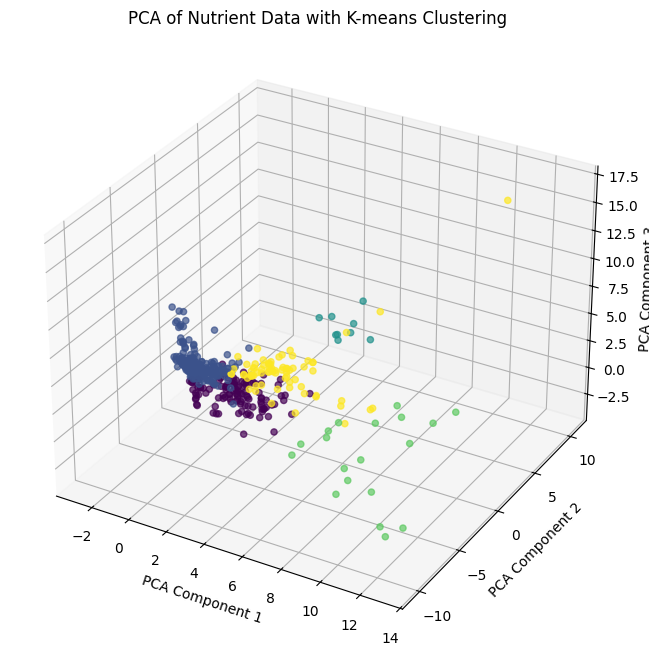

In [21]:
nutr_df_grouped = pd.read_csv('collapsed_ingredients.csv')

numeric_columns = nutr_df_grouped.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('Nutrient Data Bank Number')
print(numeric_columns)

nutr_numeric_df = nutr_df_grouped[numeric_columns]

# Check #1
print(nutr_numeric_df.head())

scaler = StandardScaler()
nutr_scaled = scaler.fit_transform(nutr_numeric_df)


# figure out ingredient clusters based on their nutritional values
kmeans = KMeans(n_clusters=5)
nutr_df_grouped['Cluster'] = kmeans.fit_predict(nutr_scaled)  

# check #2
print(nutr_df_grouped[['simple_ingr', 'Cluster']].head())

# PCA with 3 components
pca = PCA(n_components=3)
nutr_pca = pca.fit_transform(nutr_scaled)

# Create a DataFrame for the PCA results
nutr_pca_df = pd.DataFrame(nutr_pca, columns=["PCA Component 1", "PCA Component 2", "PCA Component 3"])

nutr_pca_df["Cluster"] = nutr_df_grouped["Cluster"]  # add cluster to the datagrame

# Add the ingredient names (from 'simple_ingr') to the PCA results for labeling
nutr_pca_df["Ingredient"] = nutr_df_grouped["simple_ingr"]

print(nutr_pca_df.head())

# Plotting the 3D PCA results with cluster coloring
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of PCA results with color representing clusters
scatter = ax.scatter(nutr_pca_df["PCA Component 1"],  nutr_pca_df["PCA Component 2"], nutr_pca_df["PCA Component 3"],   c=nutr_pca_df["Cluster"], cmap='viridis', alpha=0.7)

# Add labels and title
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("PCA of Nutrient Data with K-means Clustering")

# Show the plot
plt.show()


nutr_df_grouped.to_csv('final_ingredients.csv', index=False)

## Now we will use this PCA to suggest a similar ingredient based on the PCA-defined nutrient list

In [22]:
def suggest_similar_ingredient(input_ingredient):
    ## this will only work if the ingredient input already exists in the ingredients dataset, otherwise it cant match it to anything
    ## make sure its lower case string then check if in the dataset
    input_data = nutr_df_grouped[nutr_df_grouped['simple_ingr'].str.lower() == input_ingredient.lower()]
    
    if input_data.empty:
        print("Ingredient '" + input_ingredient + "' not found in the dataset.")
        return  
    
    # PCA coordinates 
    input_index = input_data.index[0]
    input_pca_coordinates = nutr_pca_df.loc[input_index, ["PCA Component 1", "PCA Component 2", "PCA Component 3"]]
    
    # cluster # for the input ingredient
    input_cluster = nutr_df_grouped.at[input_index, "Cluster"]

    # only keep the same cluster
    cluster_df = nutr_pca_df[nutr_pca_df["Cluster"] == input_cluster]
    
    # to find the ingredient with the closest PCA value, calculate the distance between the PCA components
    pca_similarities = []
    
    # Loop over each row in the cluster_df and calculate the difference for each PCA component and the input value
    for i, row in cluster_df.iterrows():
        similarity = abs(row["PCA Component 1"] - input_pca_coordinates["PCA Component 1"]) + \
                    abs(row["PCA Component 2"] - input_pca_coordinates["PCA Component 2"]) + \
                    abs(row["PCA Component 3"] - input_pca_coordinates["PCA Component 3"])
        
        pca_similarities.append(similarity)  
    
    # put it back in the dataframe
    cluster_df["PCA Similarity"] = pca_similarities
    
    # to make sure it doesnt recommend the same ingredient back, we need to drop the original from the dataset (so if input is butter, drop butter)
    cluster_df = cluster_df[cluster_df["Ingredient"].str.lower() != input_ingredient.lower()]
    
    # loop to figure out which is the closest ingredient -- keep track of smallest value for similarity
    min_similarity = float('inf') 
    closest_ingredient = None
    for index, row in cluster_df.iterrows():
        similarity = row["PCA Similarity"]
        if similarity < min_similarity:
            min_similarity = similarity
            closest_ingredient = row["Ingredient"]
    
    print("The most similar ingredient to '" + input_ingredient + "' is '" + closest_ingredient + "' with a PCA similarity score of " + str(min_similarity) + ".")


# tests for multiple ingredients
print(suggest_similar_ingredient("butter"))
print(suggest_similar_ingredient("margarine"))
print(suggest_similar_ingredient("egg"))
print(suggest_similar_ingredient("apple"))


The most similar ingredient to 'butter' is 'Margarine' with a PCA similarity score of 1.2181364457513102.
None
The most similar ingredient to 'margarine' is 'Butter' with a PCA similarity score of 1.2181364457513102.
None
The most similar ingredient to 'egg' is 'Pâté' with a PCA similarity score of 3.950475490984259.
None
The most similar ingredient to 'apple' is 'Pomegranate' with a PCA similarity score of 0.25509294363602786.
None


/tmp/ipykernel_2689/858289547.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["PCA Similarity"] = pca_similarities
/tmp/ipykernel_2689/858289547.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["PCA Similarity"] = pca_similarities
/tmp/ipykernel_2689/858289547.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/